In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

### Face Image 읽어오기 

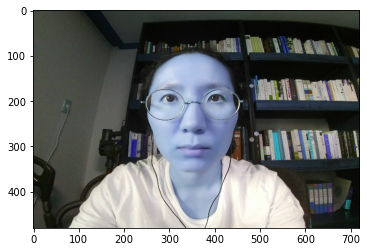

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/face.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (720, 480))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

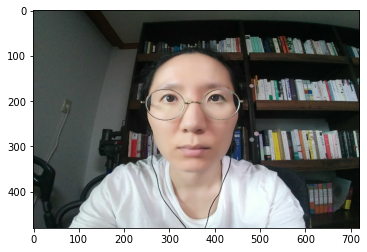

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Object detection

### dlib 을 활용해 hog detedtor 선언하기 

- dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾습니다. HOG와 SVM의 자세한 알고리즘은 아래 링크를 참고해 주세요. (한국어 버전도 있습니다.)

- [딥러닝(Deep Learning)을 사용한 최신 얼굴 인식(Face Recognition)](https://medium.com/@jongdae.lim/기계-학습-machine-learning-은-즐겁다-part-4-63ed781eee3c) (한국어 번역본)
- [Machine Learning is Fun! Part 4: Modern Face Recognition with Deep Learning](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78) (영어 원본)

In [4]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

### detectror를 이용해 얼굴 bounding box 추출


In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

- dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환한다.

- detector_hog의 두 번째 파라미터는 이미지 피라미드의 수입니다. 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다. 이미지 피라미드에 대한 내용은 아래 링크를 참고해 주세요.

- [Image Pyramids - gramman 0.1 documentation](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)

rectangles[[(241, 142) (464, 365)]]


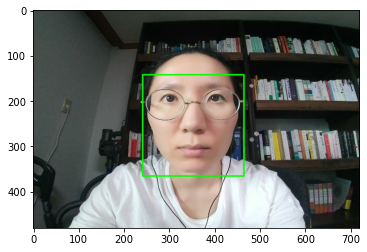

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

dlib detector 는 `dlib.rectangles` 타입의 객체를 반환합니다.

`dlib.rectangles` 는 `dlib.rectangle` 객체의 배열 형태로 이루어져 있습니다.

`dlib.rectangle`객체는 `left(), top(), right(), bottom(), height(), width()` 등의 멤버 함수를 포함하고 있습니다. 더 자세한 정보는 dlib docs를 참고해주세요.

### 저장한 landmark 모델을 불러오기

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

`landmark_predictor` 는 `RGB 이미지`와 `dlib.rectangle`을 입력 받아 `dlib.full_object_detection` 를 반환합니다.

In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


`points` 는 `dlib.full_object_detection` 의 객체이기 때문에 `parts()` 함수로 개별 위치에 접근할 수 있습니다. 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었습니다. 따라서 `list_points` 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다. 이미지에서 찾아진 얼굴 개수마다 반복하면 `list_landmark`에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.

### Land mark 출력하기 

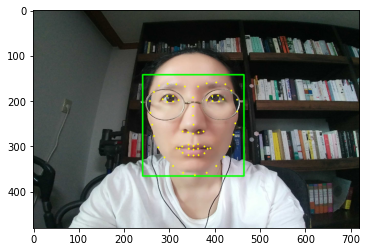

In [9]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용하기 

- land mark 좌표확인 
- land mark를 기준으로 입술 위 에 스티커 씌우기 


### 좌표 확인 

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) 
    x = landmark[33][0] 
    y = landmark[33][1] - dlib_rect.width()// 80
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(352, 272)
(x,y) : (352,270)
(w,h) : (224,224)


- 코의 중심점 좌표가 (353, 299)

### 스티커 가져오기  

- 수염 이미지를 읽고 윗 단계에서 계산한 크기로 resize 합니다.

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(224, 224, 3)


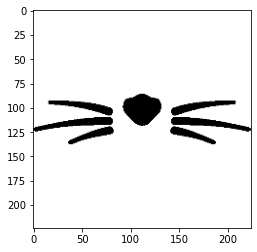

In [12]:
plt.imshow(img_sticker)
plt.show()

### 원본 이미지에 스티커 이미지를 추가하기 

- x, y 좌표를 조정합니다. 
- 이미지 시작점은 top-left 좌표이기 때문입니다.

```
(353, 320)
(x,y) : (353,207)
(w,h) : (224,224)
```

1. 스티커 위치 

$$
\begin{aligned} x &= x_{nose} \\ y &= y_{nose}-\frac{width}{2} \end{aligned}
$$

2. 스티커 크기 

$$
width=height=width_{bbox}
$$ 

- 중요한 것은 얼굴 위치, 카메라의 거리에 따라 픽셀 x 가 다르기 때문에 비율로 계산을 해줘야 합니다. 계산할 수치는 두 가지 입니다.

In [13]:
refined_x = x - w // 2  # left
refined_y = y - h // 2       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (240,158)


In [14]:
# refined_x = x - (landmark[30][0]-landmark[36][0])*2 // 2  # left
# refined_y = y - (landmark[2][1]-landmark[48][1])*2       # top
# print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [15]:
# img_sticker = img_sticker[-refined_y:]
# print (img_sticker.shape)

In [16]:
# print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

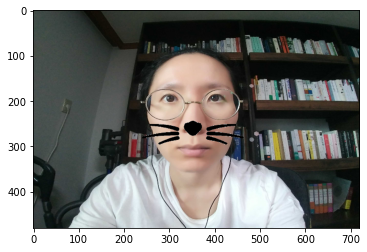

In [17]:
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


 -  얻어걸렸다. 
 -  Land Mark Point를 기준으로 위치 조정하는 부분에 대해 잘 이해하지 못했다. 
 

##  문제점 찾아보기

(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!


> - 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
> - 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
> - 실행 속도가 중요할까요?
> - 스티커앱을 만들 때 정확도가 얼마나 중요할까요?